[View in Colaboratory](https://colab.research.google.com/github/varunbhanot/CV_Using_DL/blob/master/MNIST.ipynb)

In [1]:
!pip install kaggle

In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!kaggle competitions list

ref                                             deadline             category            reward  teamCount  userHasEntered  
----------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
house-prices-advanced-regression-techniques     2030-01-01 00:00:00  Getting Started  Knowledge       4958           False  
digit-recognizer                                2030-01-01 00:00:00  Getting Started  Knowledge       2782           False  
titanic                                         2030-01-01 00:00:00  Getting Started  Knowledge      11303            True  
imagenet-object-detection-challenge             2029-12-31 07:00:00  Research         Knowledge          0           False  
imagenet-object-detection-from-video-challenge  2029-12-31 07:00:00  Research         Knowledge          0           False  
imagenet-object-localization-challenge          2029-12-31 07:00:00  Research         Knowledge         16           False  


In [5]:
!kaggle competitions download  -c digit-recognizer -p /content/digit_recogniser/kaggle

 70%|██████████████████████████▍           | 51.0M/73.2M [00:00<00:00, 50.0MB/s]
100%|███████████████████████████████████████| 73.2M/73.2M [00:00<00:00, 156MB/s]
 62%|███████████████████████▍              | 30.0M/48.8M [00:00<00:00, 40.8MB/s]
100%|███████████████████████████████████████| 48.8M/48.8M [00:00<00:00, 147MB/s]
  0%|                                                | 0.00/235k [00:00<?, ?B/s]
100%|█████████████████████████████████████████| 235k/235k [00:00<00:00, 161MB/s]


In [23]:
import pandas as pd
train = pd.read_csv('/content/digit_recogniser/kaggle/train.csv', header=0, sep=',', quotechar='"')
test = pd.read_csv('/content/digit_recogniser/kaggle/test.csv', header=0, sep=',', quotechar='"')

In [25]:
Y_train = train["label"]
# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 
Y_train.shape

(42000,)

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

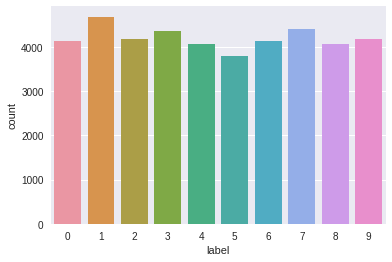

In [27]:
g = sns.countplot(Y_train)

Y_train.value_counts()

In [28]:
X_train.isnull().any().describe()


count       784
unique        1
top       False
freq        784
dtype: object

In [29]:
X_train = X_train / 255.0
test = test / 255.0

In [30]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [31]:
import numpy as np
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [32]:
Y_train = to_categorical(Y_train, num_classes = 10)
Y_train.shape

(42000, 10)

In [34]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)
Y_train.shape

(34020, 10)

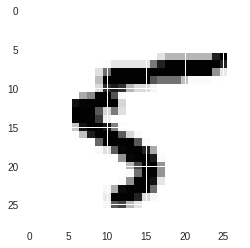

In [35]:
g = plt.imshow(X_train[0][:,:,0])

In [36]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [37]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [38]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [42]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86
Y_train.shape

(34020, 10)

In [43]:
# Without data augmentation i obtained an accuracy of 0.98114
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, Y_val), verbose = 2)

Train on 34020 samples, validate on 3780 samples
Epoch 1/30
 - 7s - loss: 0.0754 - acc: 0.9776 - val_loss: 0.0573 - val_acc: 0.9831
Epoch 2/30
 - 8s - loss: 0.0559 - acc: 0.9837 - val_loss: 0.0511 - val_acc: 0.9873
Epoch 3/30
 - 7s - loss: 0.0435 - acc: 0.9864 - val_loss: 0.0481 - val_acc: 0.9868
Epoch 4/30
 - 7s - loss: 0.0395 - acc: 0.9880 - val_loss: 0.0396 - val_acc: 0.9889
Epoch 5/30
 - 7s - loss: 0.0363 - acc: 0.9896 - val_loss: 0.0450 - val_acc: 0.9902
Epoch 6/30
 - 7s - loss: 0.0322 - acc: 0.9902 - val_loss: 0.0411 - val_acc: 0.9913
Epoch 7/30
 - 7s - loss: 0.0322 - acc: 0.9904 - val_loss: 0.0418 - val_acc: 0.9897
Epoch 8/30
 - 7s - loss: 0.0305 - acc: 0.9912 - val_loss: 0.0500 - val_acc: 0.9894
Epoch 9/30
 - 7s - loss: 0.0261 - acc: 0.9918 - val_loss: 0.0494 - val_acc: 0.9907
Epoch 10/30
 - 7s - loss: 0.0265 - acc: 0.9923 - val_loss: 0.0427 - val_acc: 0.9899
Epoch 11/30
 - 7s - loss: 0.0259 - acc: 0.9925 - val_loss: 0.0465 - val_acc: 0.9915
Epoch 12/30
 - 7s - loss: 0.0239 - a

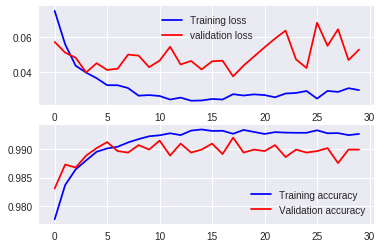

In [44]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [49]:
results = model.predict(test)
results

array([[3.0076687e-16, 5.5408139e-18, 1.0000000e+00, ..., 6.0940599e-14,
        2.6032037e-12, 5.4588722e-16],
       [1.0000000e+00, 1.8867967e-14, 8.3377509e-09, ..., 7.7732569e-12,
        5.5321848e-11, 6.4395662e-11],
       [5.8103591e-16, 9.3259059e-13, 3.0067412e-10, ..., 2.1520952e-09,
        4.0464315e-07, 9.9991930e-01],
       ...,
       [0.0000000e+00, 8.5145960e-28, 1.1660760e-23, ..., 3.8619368e-24,
        6.7641756e-22, 4.6616177e-25],
       [1.5627144e-19, 4.0230394e-20, 6.2567114e-18, ..., 3.2590868e-13,
        2.0367323e-13, 1.0000000e+00],
       [2.0643573e-23, 1.7922334e-21, 1.0000000e+00, ..., 2.3205117e-18,
        2.0599742e-13, 1.0577611e-18]], dtype=float32)

In [50]:
results = np.argmax(results,axis = 1)
results

array([2, 0, 9, ..., 3, 9, 2])

In [52]:
results = pd.Series(results,name="Label")

In [53]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

In [54]:
submission.to_csv("cnn_mnist_datagen.csv",index=False)

In [60]:
!kaggle competitions submit -c digit-recognizer -f cnn_mnist_datagen.csv -m "submission" 

Successfully submitted to Digit Recognizer